# 第 12 周（第二部分）
3220190783 陈子康

GitHub 地址：https://github.com/czyczk/data-mining-course

本部分作业使用 Wave Benchmarks 数据集。

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.models.xgbod import XGBOD
from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from MulticoreTSNE import MulticoreTSNE as TSNE

In [2]:
# Lib config
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

## 1 Wave Benchmarks
### 1.1 导入数据集并合并
选择数据集中的前 25 个 .csv 文件（约 8 万条数据）作为训练集，后 1/4 作为测试集。

即 0001 到 0025 为训练集，1231 到 1640（最后一个）为测试集。

In [3]:
range_train = range(1, 26)
range_test = range(1231, 1641)

# Wine benchmarks dataset
data_wave_train_list = []
try:    
    for i in range_train:
        data_wave_train_list.append(pd.read_csv('../Datasets/Wave_Benchmarks/wave/benchmarks/wave_benchmark_{:04d}.csv'.format(i)))
except FileNotFoundError:
    # Some files (e.g. whose indexes are in range of [0481, 0600]) are missing. Just skip them.
    pass

data_wave_test_list = []
try:    
    for i in range_test:
        data_wave_test_list.append(pd.read_csv('../Datasets/Wave_Benchmarks/wave/benchmarks/wave_benchmark_{:04d}.csv'.format(i)))
except FileNotFoundError:
    pass


In [4]:
data_wave_train_concatted = None
try:
    data_wave_train_concatted = pd.concat(data_wave_train_list, ignore_index = True, verify_integrity = True, sort = False)
except ValueError as e:
    print('ValueError:', e)
# data_crime_concatted.reset_index(drop = True, inplace = True)

data_wave_test_concatted = None
try:
    data_wave_test_concatted = pd.concat(data_wave_test_list, ignore_index = True, verify_integrity = True, sort = False)
except ValueError as e:
    print('ValueError:', e)

为数据集标记异常，若在 `ground.truth` 标签为 "anomaly"，则计为 1，否则计为 0。

In [5]:
def derive_is_anomaly_col(df):
    if df['ground.truth'] == 'anomaly':
        return 1
    else:
        return 0

In [6]:
data_wave_train_concatted['is.anomaly'] = data_wave_train_concatted.apply(derive_is_anomaly_col, axis = 1)
data_wave_train_x = data_wave_train_concatted.loc[:, 'V':'V.20']
data_wave_train_y = data_wave_train_concatted.loc[:, 'is.anomaly']

In [7]:
data_wave_test_concatted['is.anomaly'] = data_wave_test_concatted.apply(derive_is_anomaly_col, axis = 1)
data_wave_test_x = data_wave_test_concatted.loc[:, 'V':'V.20']
data_wave_test_y = data_wave_test_concatted.loc[:, 'is.anomaly']

选取一部分作为试训练集，在正式报告中忽略以下部分。

In [8]:
lite_scope = 100
data_wave_train_x_lite = data_wave_train_x.loc[0:lite_scope, :]
data_wave_train_y_lite = data_wave_train_y.loc[0:lite_scope]

### 1.2 XGBOD

In [9]:
clf_xgbod = XGBOD(random_state = 42)
clf_xgbod.fit(data_wave_train_x, data_wave_train_y)

C:\tools\Anaconda3\lib\site-packages\pyod\models\base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")
C:\tools\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\tools\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\tools\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly 

[16:18:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBOD(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1,
   estimator_list=[KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2,
  radius=1.0), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=1, p=...x_features=1.0,
    max_samples='auto', n_estimators=200, n_jobs=1, random_state=42,
    verbose=0)],
   gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
   min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
   nthread=None, objective='binary:logistic', random_state=42, reg_alpha=0,
   reg_lambda=1, scale_pos_weight=1, silent=True,
   standardization_flag_list=[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, False, False, 

In [10]:
xgbod_train_y_pred = clf_xgbod.labels_
xgbod_train_y_scores = clf_xgbod.decision_scores_

计算在**训练集**上的**准确率**。

In [11]:
def calculate_accuracy(ground_truths, predictions):
    '''
    The result will be in the order of "true positive", "false positive", "false negative", "true negative".
    '''
    num_true_positive = 0
    num_false_positive = 0
    num_false_negative = 0
    num_true_negative = 0

    for i in range(len(predictions)):
        if predictions[i] == 1 and ground_truths[i] == 1:
            num_true_positive += 1
        elif predictions[i] == 1 and ground_truths[i] == 0:
            num_false_positive += 1
        elif predictions[i] == 0 and ground_truths[i] == 1:
            num_false_negative += 1
        else:
            num_true_negative += 1
    
    return (num_true_positive, num_false_positive, num_false_negative, num_true_negative)

In [12]:
xgbod_num_true_positive, xgbod_num_false_positive, xgbod_num_false_negative, xgbod_num_true_negative = calculate_accuracy(data_wave_train_y, xgbod_train_y_pred)

In [13]:
print('TP: {}\nFP: {}\nFN: {}\nTN: {}'.format(xgbod_num_true_positive, xgbod_num_false_positive, xgbod_num_false_negative, xgbod_num_true_negative))
precision = xgbod_num_true_positive / (xgbod_num_true_positive + xgbod_num_false_positive)
recall = xgbod_num_true_positive / (xgbod_num_true_positive + xgbod_num_false_negative)
accuracy = (xgbod_num_true_positive + xgbod_num_true_negative) / len(xgbod_train_y_pred)
f1_score = 2 * recall * precision / (recall + precision)
print('Percision: {}\nRecall: {}'.format(precision, recall))
print('Accuracy: {}'.format(accuracy))
print('F1 Score: {}'.format(f1_score))
evaluate_print('XGBOD', data_wave_train_y, xgbod_train_y_scores)

TP: 22742
FP: 2430
FN: 2432
TN: 47646
Percision: 0.9034641665342444
Recall: 0.9033923889727496
Accuracy: 0.9353887043189368
F1 Score: 0.9034282763278115
XGBOD ROC:0.9842, precision @ rank n:0.9035


使用**测试集**预测并计算在其上的**准确率**。

In [14]:
xgbod_test_y_pred = clf_xgbod.predict(data_wave_test_x)
xgbod_test_y_scores = clf_xgbod.decision_function(data_wave_test_x)

In [15]:
xgbod_num_true_positive, xgbod_num_false_positive, xgbod_num_false_negative, xgbod_num_true_negative = calculate_accuracy(data_wave_test_y, xgbod_test_y_pred)

In [16]:
print('TP: {}\nFP: {}\nFN: {}\nTN: {}'.format(xgbod_num_true_positive, xgbod_num_false_positive, xgbod_num_false_negative, xgbod_num_true_negative))
precision = xgbod_num_true_positive / (xgbod_num_true_positive + xgbod_num_false_positive)
recall = xgbod_num_true_positive / (xgbod_num_true_positive + xgbod_num_false_negative)
accuracy = (xgbod_num_true_positive + xgbod_num_true_negative) / len(xgbod_test_y_pred)
f1_score = 2 * recall * precision / (recall + precision)
print('Percision: {}\nRecall: {}'.format(precision, recall))
print('Accuracy: {}'.format(accuracy))
print('F1 Score: {}'.format(f1_score))
evaluate_print('XGBOD', data_wave_test_y, xgbod_test_y_scores)

TP: 12802
FP: 14436
FN: 1508
TN: 256284
Percision: 0.4700051398781115
Recall: 0.8946191474493361
Accuracy: 0.9440620285583974
F1 Score: 0.6162510830846251
XGBOD ROC:0.9818, precision @ rank n:0.742


使用 **T-SNE 将高维数据降维至 2 维**，以便可视化展示。

In [17]:
# TSNE (prep for visualization)
tsne = TSNE(n_components = 2, n_jobs = 8)
tsne_train_x = tsne.fit_transform(data_wave_train_x)
tsne_test_x = tsne.fit_transform(data_wave_test_x)

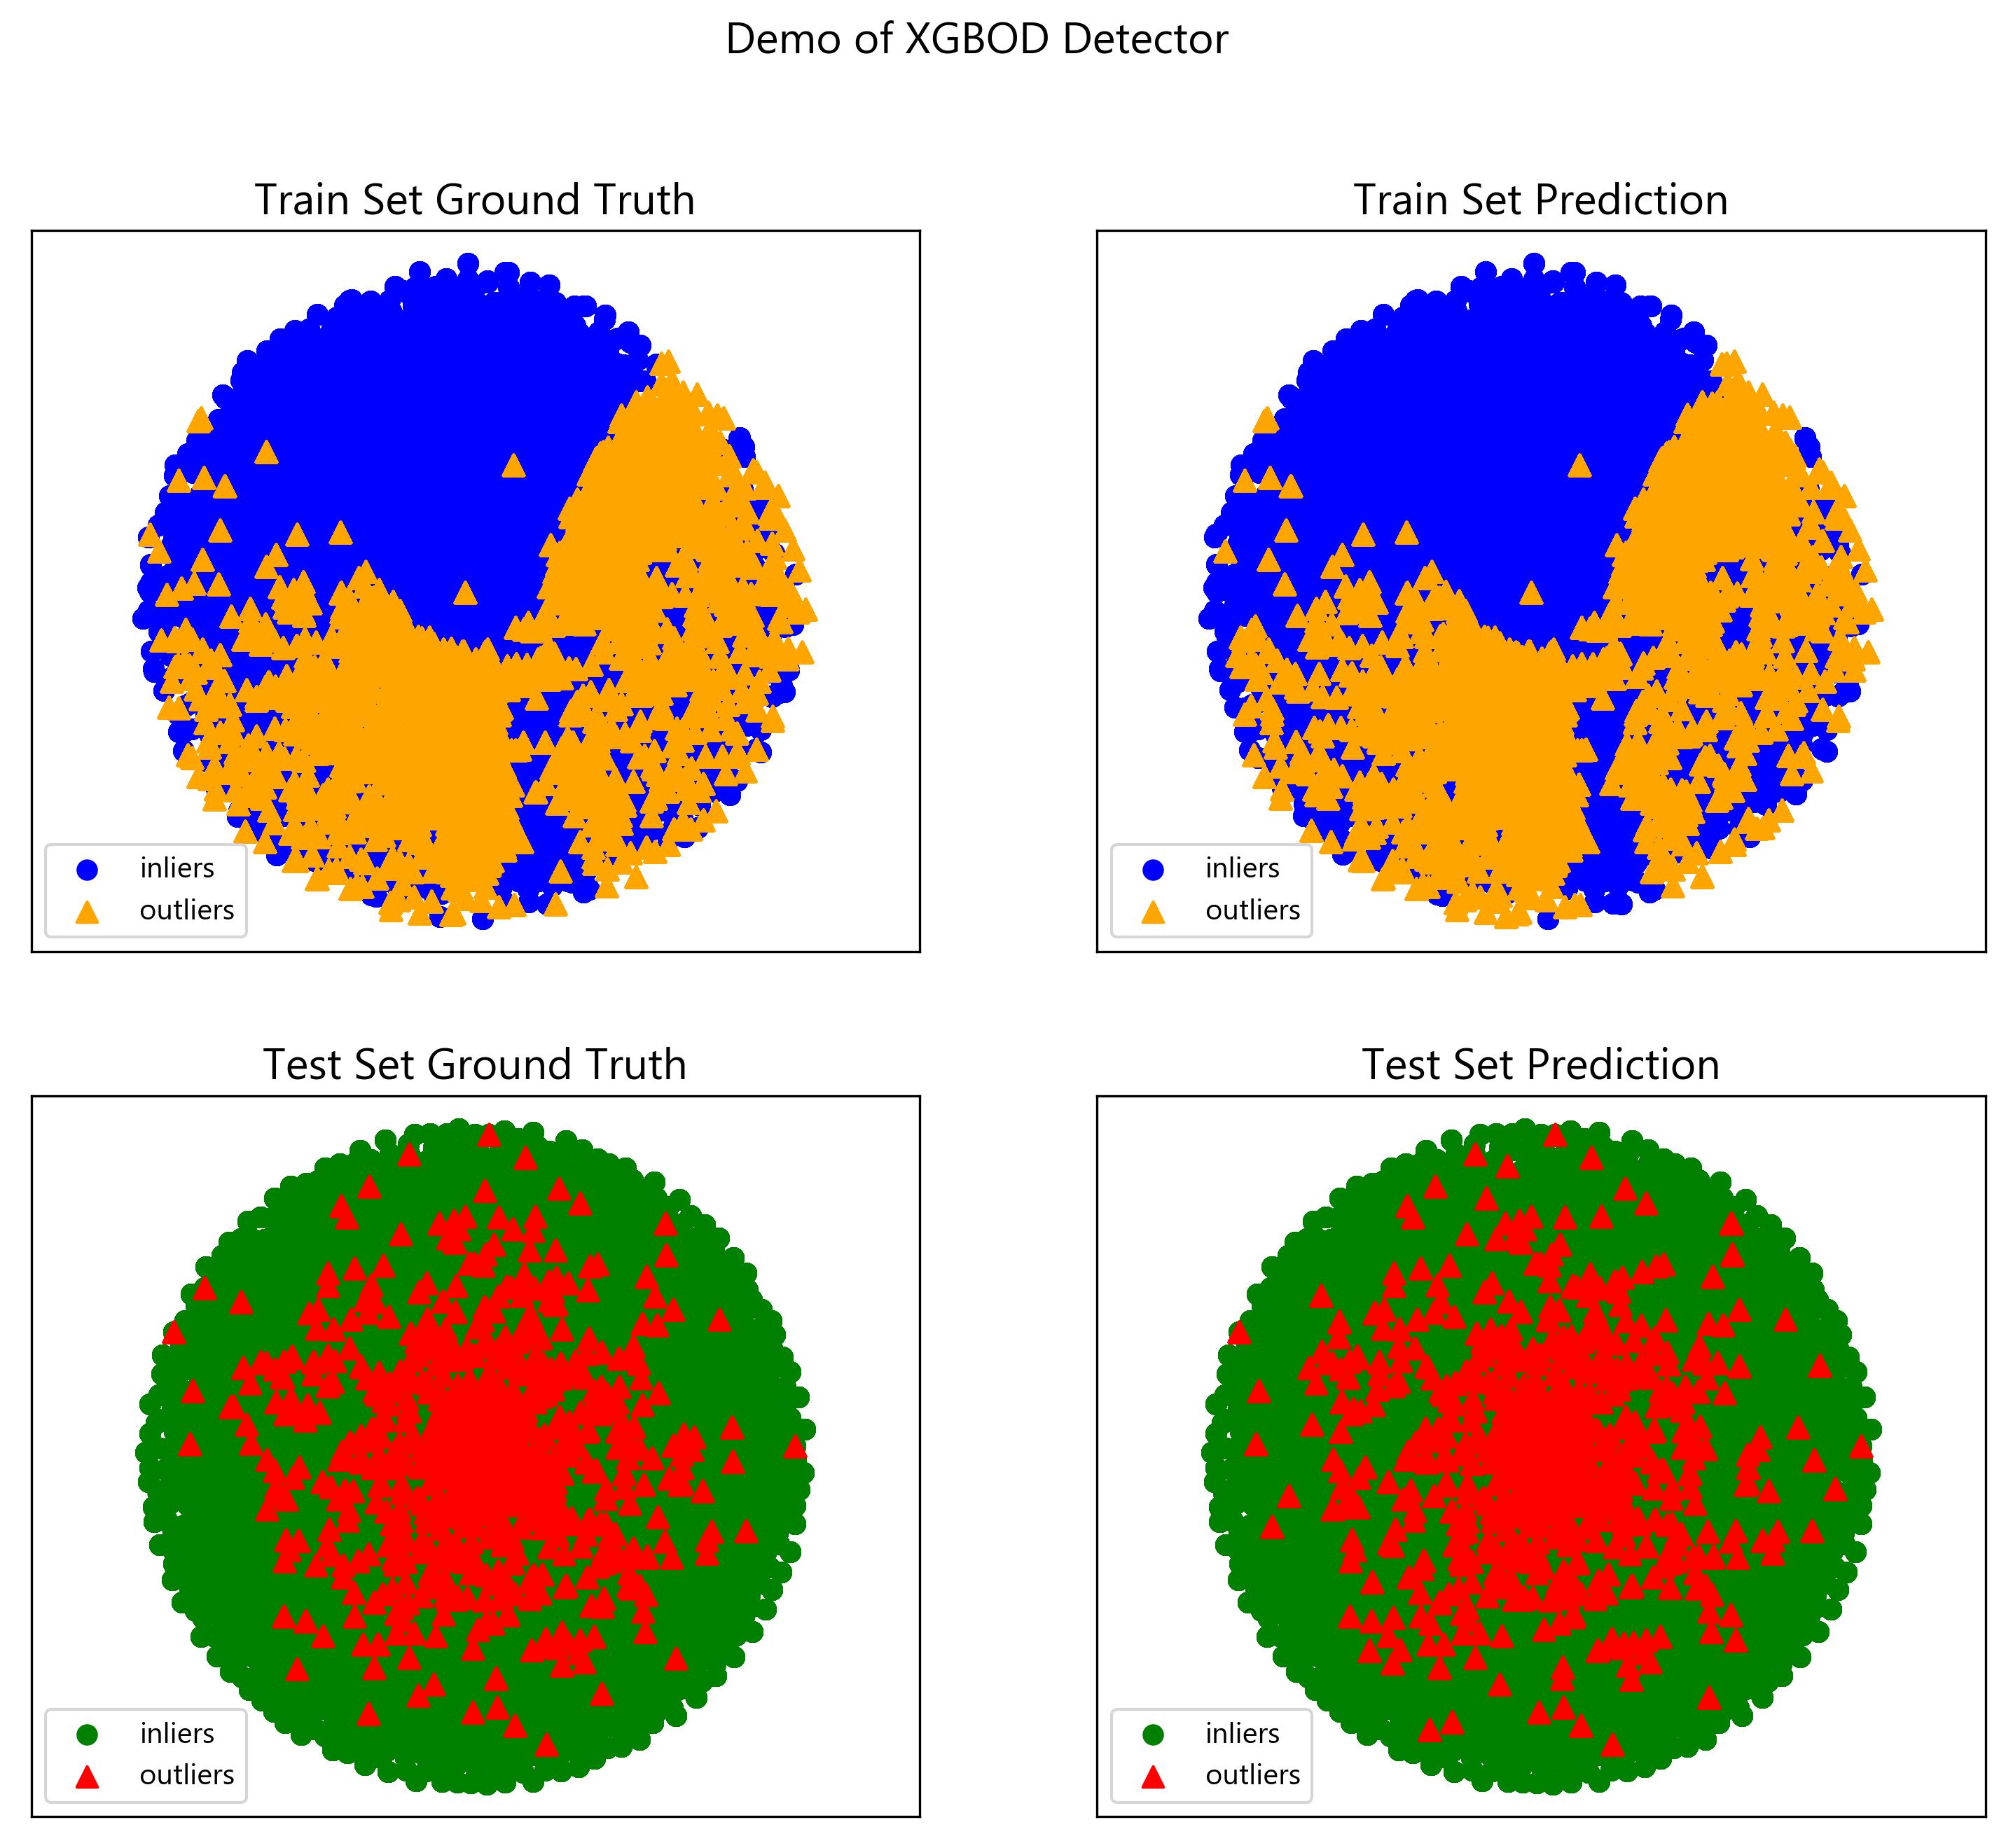

In [18]:
# Visualization
visualize('XGBOD', tsne_train_x, data_wave_train_y, tsne_test_x, data_wave_test_y, xgbod_train_y_pred,
xgbod_test_y_pred, show_figure = True, save_figure = False)

### 1.3 Isolation Forest

In [30]:
# Train Isolation Forest detector
clf_iforest = IForest()
clf_iforest.fit(data_wave_train_x)

C:\tools\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [32]:
iforest_train_y_pred = clf_iforest.labels_
iforest_train_y_scores = clf_iforest.decision_scores_

计算在**训练集**上的**准确率**。

In [33]:
iforest_num_true_positive, iforest_num_false_positive, iforest_num_false_negative, iforest_num_true_negative = calculate_accuracy(data_wave_train_y, iforest_train_y_pred)

In [39]:
print('TP: {}\nFP: {}\nFN: {}\nTN: {}'.format(iforest_num_true_positive, iforest_num_false_positive, iforest_num_false_negative, iforest_num_true_negative))
precision = iforest_num_true_positive / (iforest_num_true_positive + iforest_num_false_positive)
recall = iforest_num_true_positive / (iforest_num_true_positive + iforest_num_false_negative)
accuracy = (iforest_num_true_positive + iforest_num_true_negative) / len(iforest_train_y_pred)
f1_score = 2 * recall * precision / (recall + precision)
print('Percision: {}\nRecall: {}'.format(precision, recall))
print('Accuracy: {}'.format(accuracy))
print('F1 Score: {}'.format(f1_score))
evaluate_print('Isolation Forest', data_wave_train_y, iforest_train_y_scores)

TP: 1630
FP: 27439
FN: 12680
TN: 243281
Percision: 0.05607348033988097
Recall: 0.11390635918937805
Accuracy: 3.2546312292358803
F1 Score: 0.07515157103667673
Isolation Forest ROC:0.4894, precision @ rank n:0.334


使用**测试集**预测并计算在其上的**准确率**。

In [35]:
iforest_test_y_pred = clf_iforest.predict(data_wave_test_x)
iforest_test_y_scores = clf_iforest.decision_function(data_wave_test_x)

In [36]:
iforest_num_true_positive, iforest_num_false_positive, iforest_num_false_negative, iforest_num_true_negative = calculate_accuracy(data_wave_test_y, iforest_test_y_pred)

In [40]:
print('TP: {}\nFP: {}\nFN: {}\nTN: {}'.format(iforest_num_true_positive, iforest_num_false_positive, iforest_num_false_negative, iforest_num_true_negative))
precision = iforest_num_true_positive / (iforest_num_true_positive + iforest_num_false_positive)
recall = iforest_num_true_positive / (iforest_num_true_positive + iforest_num_false_negative)
accuracy = (iforest_num_true_positive + iforest_num_true_negative) / len(iforest_test_y_pred)
f1_score = 2 * recall * precision / (recall + precision)
print('Percision: {}\nRecall: {}'.format(precision, recall))
print('Accuracy: {}'.format(accuracy))
print('F1 Score: {}'.format(f1_score))
evaluate_print('Isolation Forest', data_wave_test_y, iforest_test_y_scores)

TP: 1630
FP: 27439
FN: 12680
TN: 243281
Percision: 0.05607348033988097
Recall: 0.11390635918937805
Accuracy: 0.8592463951163035
F1 Score: 0.07515157103667673
Isolation Forest ROC:0.4971, precision @ rank n:0.0608


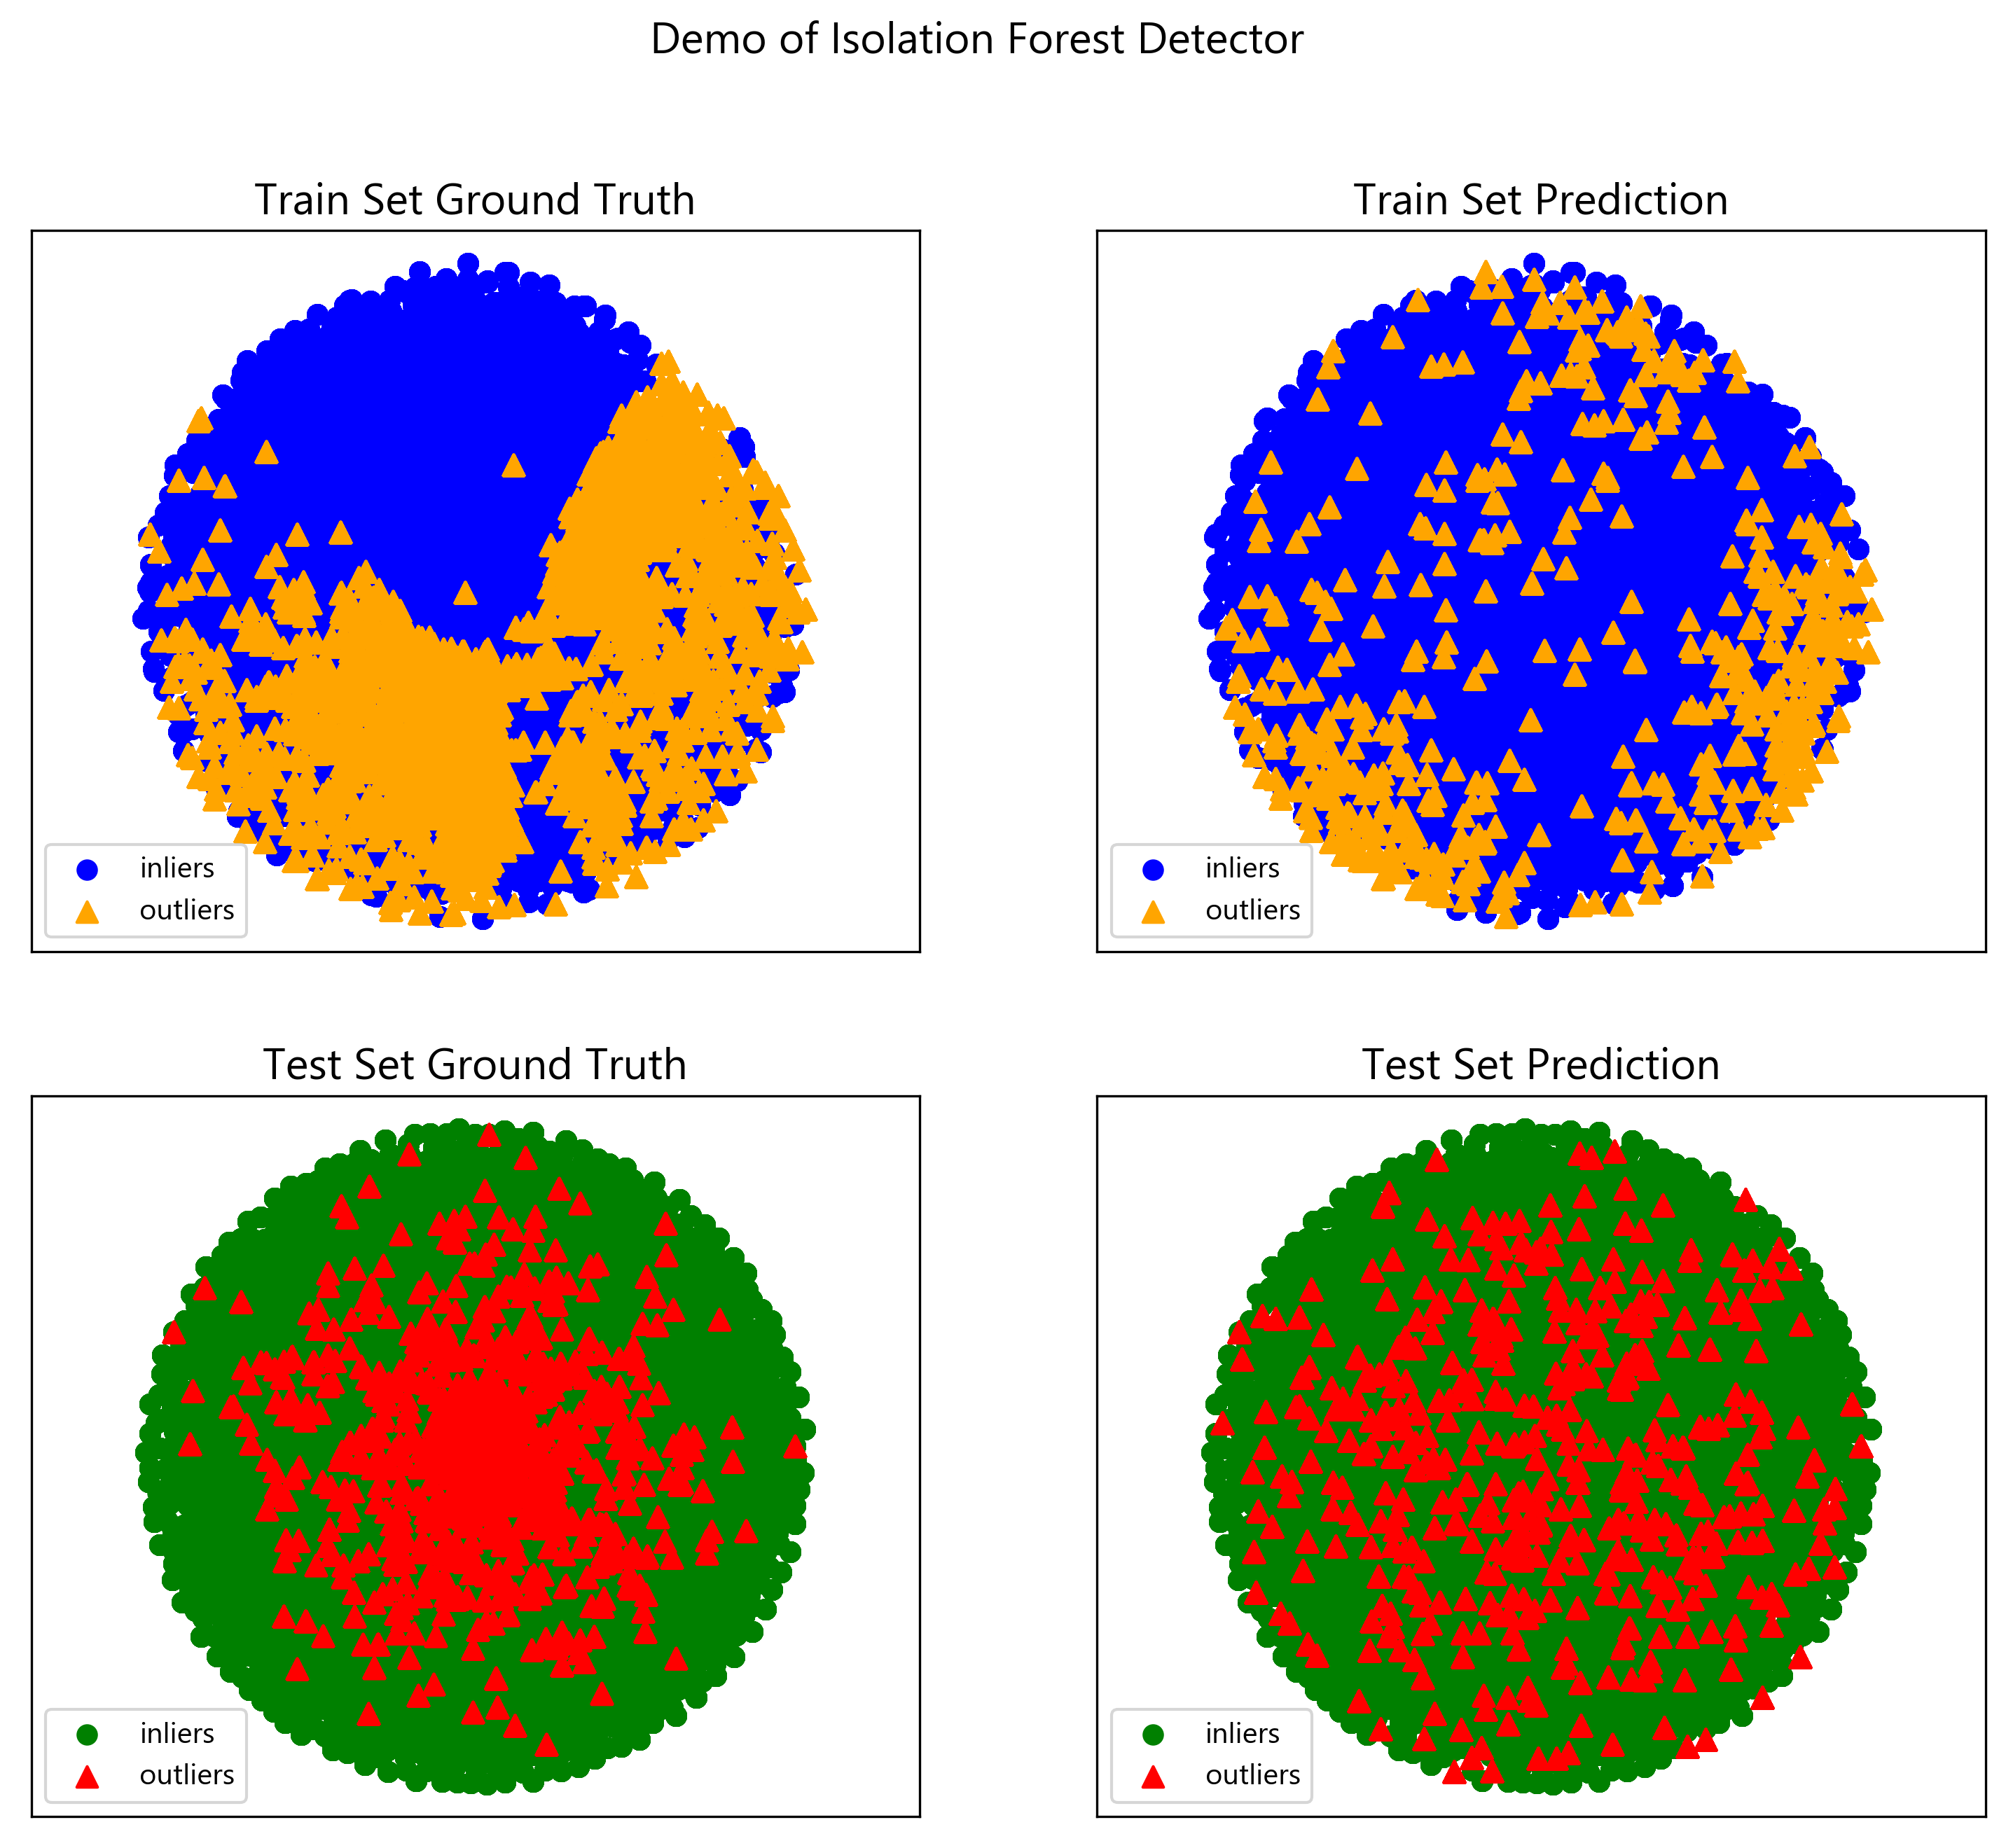

In [38]:
# Visualization
visualize('Isolation Forest', tsne_train_x, data_wave_train_y, tsne_test_x, data_wave_test_y, iforest_train_y_pred,
iforest_test_y_pred, show_figure = True, save_figure = False)

### 1.4 总结
使用了 XGBoost 和 Isolation Forest 两种方法检测异常值，其中前者为监督方法，后者为非监督方法。

从两种模型在测试集上分别进行预测得到的结果中可以看出，

XGBoost 的 accuracy 为 0.944，F1 score 为 0.616，ROC 为 0.982；

Isolation Forest 的 accuracy 为 0.859，F1 score 为 0.0752，ROC 为 0.497；

XGBoost 在这些指标上均优于 Isolation Forest，原因可能因为前者利用了数据中的标签信息，有助于提高其预测性能。